In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


# Data Preparation

In [2]:
descriptors = pd.read_csv("descriptors.csv");
print('Dimensions of data frame is', descriptors.shape);

Dimensions of data frame is (1050, 247)


In [3]:
nNullVals = descriptors.isnull().sum().sum()
print('There are', nNullVals, 'null values in the dataframe')
# Remove columns where all values are na.
descriptors = descriptors.dropna(axis='columns', how='all');
print('Dimensions of data frame are', descriptors.shape);

There are 31503 null values in the dataframe
Dimensions of data frame are (1050, 217)


In [4]:
# There still might be some NaNs in each of the rows.
nans = np.isnan(descriptors).sum().sum()
print('There are', nans, 'nans in the dataframe')

There are 3 nans in the dataframe


In [5]:
# Method for imputing nans with mean of the column, 
# so we don't have to remove the whole row if a couple of values are missing
def imputeNansWithMean (X):
    # convert to numpy array
    header = list(X)
    X = X.values
    
    if (np.isnan(X).sum()==0):
        print("No nans")
        return X
    # Array of NaN indices
    nans= np.argwhere(np.isnan(X))
    # Loop through NaNs and impute indices with means of the whole column
    for i in range(np.size(nans,0)):
        X[nans[i][0],nans[i][1]] = np.nanmean(X[:,nans[i][1]])
    return pd.DataFrame(data = X, columns = header)
        

In [6]:
descriptors = imputeNansWithMean(descriptors)

In [7]:
# There still might be some NaNs in each of the rows.
nans = np.isnan(descriptors).sum().sum()
print('There are', nans, 'nans in the dataframe')

There are 0 nans in the dataframe


In [8]:
descriptors= descriptors.drop(['Unnamed: 0'], axis =1)
descriptors.head()

,molSIDs,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nAtomLC,nB,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
0,124897530.0,1.135,369.168856,0.0,10.0,2.89,3.0,8.0,10.0,28.0,...,38.705835,0.587339,-0.212712,-0.098779,0.094417,-0.105979,4.0,6.0,28.677761,57.044239
1,124897303.0,4.498,249.095378,0.0,2.0,3.11,2.0,18.0,2.0,21.0,...,21.080331,0.140528,-0.058828,-0.015299,0.003398,0.002364,0.0,1.0,15.641484,39.578516
2,124753561.0,4.554,657.230885,0.0,11.0,4.21,0.0,9.0,4.0,52.0,...,103.548597,0.986870,-0.554960,0.077083,0.204425,-0.347424,0.0,8.0,57.764452,98.933548
3,124753354.0,8.321,501.146461,1.0,9.0,2.89,4.0,16.0,5.0,34.0,...,44.567510,0.770304,-0.337273,-0.243732,0.222481,-0.064752,2.0,4.0,40.743589,70.138411
4,121286038.0,4.515,637.224657,0.0,10.0,4.32,2.0,24.0,4.0,52.0,...,90.067994,0.906852,-0.523297,0.081751,0.016048,0.040308,2.0,6.0,53.306245,97.709755


In [9]:
scoreData = pd.read_csv("data.csv");
sid_activityScore = scoreData.loc[5:,['PUBCHEM_SID','PUBCHEM_ACTIVITY_SCORE']];

/Users/daraakdag/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,8,9,10,11,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# Because some columns have mixed values, the pandas dataframe will parse values as floating points.
sid_activityScore.head()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
5,842121.0,0.0
6,842122.0,0.0
7,842123.0,0.0
8,842124.0,0.0
9,842125.0,0.0


In [11]:
# Convert floating point values to integers. 
sid_activityScore['PUBCHEM_SID'] = sid_activityScore['PUBCHEM_SID'].astype(np.int64)
sid_activityScore['PUBCHEM_ACTIVITY_SCORE'] = sid_activityScore['PUBCHEM_ACTIVITY_SCORE'].astype(np.int64)

In [12]:
sid_activityScore.head()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
5,842121,0
6,842122,0
7,842123,0
8,842124,0
9,842125,0


In [13]:
# Insert activity score column with values 0
descriptors.insert(0,'ActivityScore',int(0))

In [14]:
descriptors.tail()

,ActivityScore,molSIDs,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nAtomLC,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
1045,0,843609.0,3.454,321.114713,0.0,8.0,2.34,2.0,12.0,6.0,...,35.829365,0.560950,-0.360243,0.116596,0.019901,-0.292837,0.0,4.0,31.140933,47.675067
1046,0,843396.0,2.894,334.121195,0.0,3.0,2.01,0.0,11.0,3.0,...,52.683298,0.668867,-0.550880,0.466517,-0.486335,0.420218,0.0,6.0,34.433726,47.746274
1047,0,843202.0,1.316,423.179421,0.0,6.0,3.11,2.0,13.0,3.0,...,53.978743,0.889698,-0.472932,-0.151360,0.434316,-0.400282,1.0,7.0,38.656175,64.459825
1048,0,842577.0,2.752,271.024932,0.0,4.0,1.79,0.0,7.0,2.0,...,25.532622,0.344138,-0.179113,-0.030790,0.078024,-0.033099,1.0,3.0,19.271070,34.726930
1049,0,842218.0,3.820,368.140389,0.0,4.0,3.00,2.0,9.0,3.0,...,39.468120,0.326019,-0.097623,-0.115749,0.072170,0.032923,0.0,4.0,28.295347,56.584653


In [15]:
# Lookup activity scores for each molSID of descriptors matrix in the sid_activityScore dataframe 
# and insert activity score into descriptor matrix. 
for idx,val in enumerate(descriptors['molSIDs']):
    temp = sid_activityScore.loc[sid_activityScore['PUBCHEM_SID']==val];
    score = temp.iloc[0][1]
    descriptors.at[idx,'ActivityScore'] = score;


In [16]:
descriptors.head()

,ActivityScore,molSIDs,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nAtomLC,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
0,0,124897530.0,1.135,369.168856,0.0,10.0,2.89,3.0,8.0,10.0,...,38.705835,0.587339,-0.212712,-0.098779,0.094417,-0.105979,4.0,6.0,28.677761,57.044239
1,0,124897303.0,4.498,249.095378,0.0,2.0,3.11,2.0,18.0,2.0,...,21.080331,0.140528,-0.058828,-0.015299,0.003398,0.002364,0.0,1.0,15.641484,39.578516
2,0,124753561.0,4.554,657.230885,0.0,11.0,4.21,0.0,9.0,4.0,...,103.548597,0.986870,-0.554960,0.077083,0.204425,-0.347424,0.0,8.0,57.764452,98.933548
3,10,124753354.0,8.321,501.146461,1.0,9.0,2.89,4.0,16.0,5.0,...,44.567510,0.770304,-0.337273,-0.243732,0.222481,-0.064752,2.0,4.0,40.743589,70.138411
4,0,121286038.0,4.515,637.224657,0.0,10.0,4.32,2.0,24.0,4.0,...,90.067994,0.906852,-0.523297,0.081751,0.016048,0.040308,2.0,6.0,53.306245,97.709755


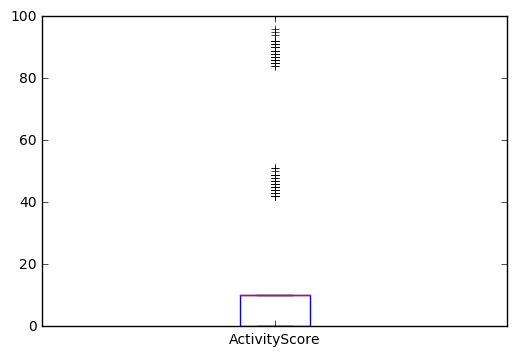

In [17]:
descriptors.ActivityScore.plot.box()

In [20]:
he.shape

(217, 217)

In [24]:
hej[0][0]

10

In [29]:
plt.rcParams["figure.figsize"] = (15,15)

In [34]:
he = np.array(descriptors.corr())
np.fill_diagonal(he,0)
hej = np.where(he>0.99)
badboy = list(set(np.array(list(descriptors))[hej[0]]))

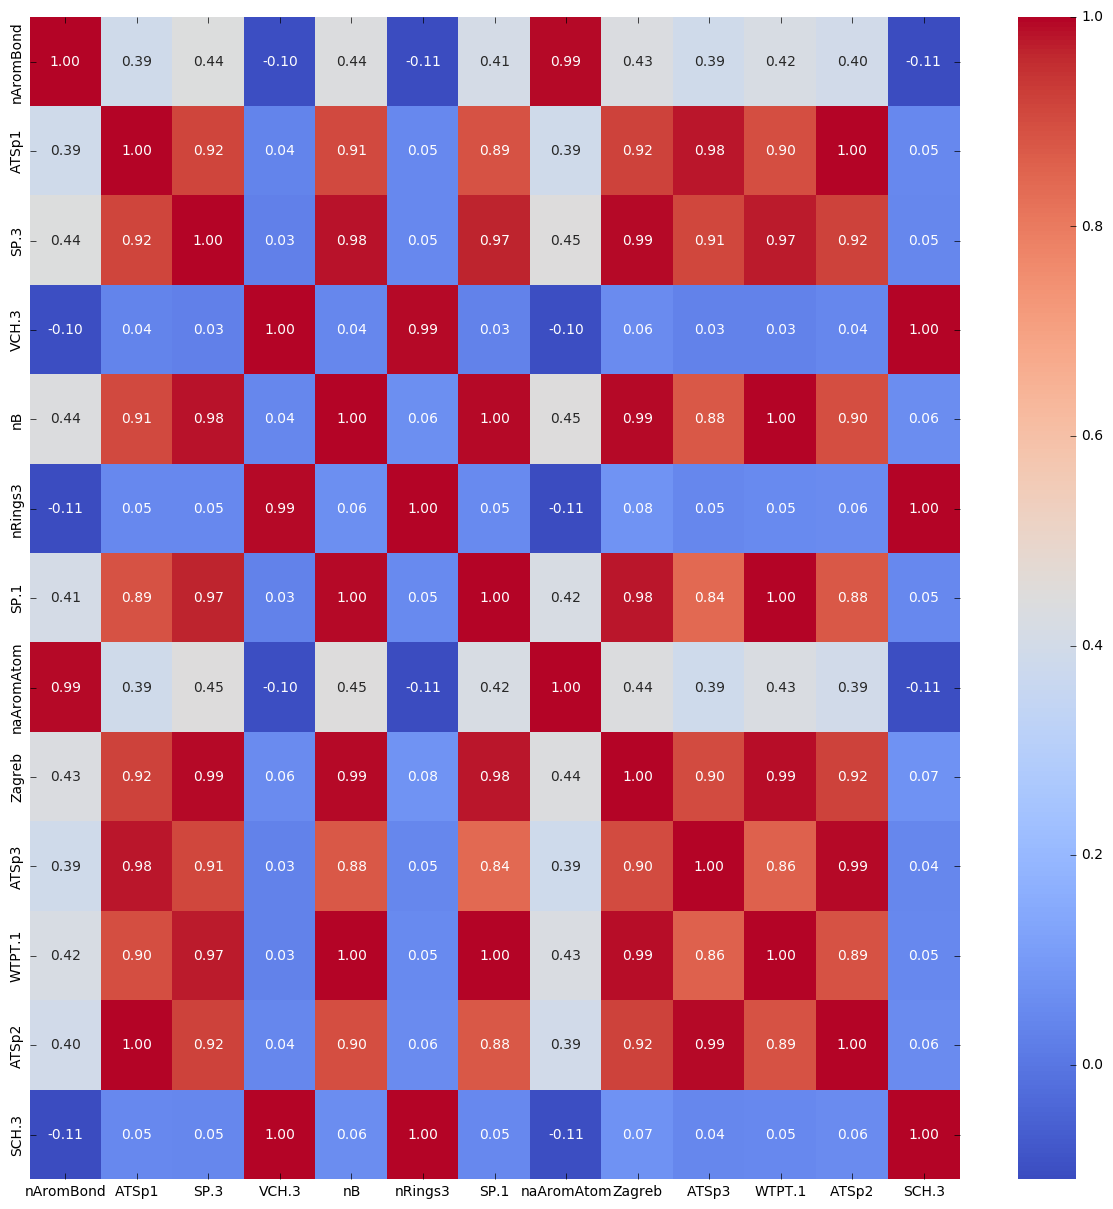

In [35]:
g = sns.heatmap(descriptors[badboy].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")


In [40]:
descriptors['nB']/descriptors['SP.1'] 

0       2.176772
1       2.251649
2       2.327202
3       2.184936
4       2.343395
5       2.314555
6       2.299547
7       2.343549
8       2.292092
9       2.307000
10      2.314555
11      2.306266
12      2.205673
13      2.278538
14      2.299870
15      2.303995
16      2.263294
17      2.232880
18      2.249501
19      2.315269
20      2.236404
21      2.278538
22      2.221278
23      2.245117
24      2.331240
25      2.242045
26      2.190566
27      2.206426
28      2.278071
29      2.308388
          ...   
1020    2.314654
1021    2.152383
1022    2.258990
1023    2.178961
1024    2.156156
1025    2.245956
1026    2.257219
1027    2.333849
1028    2.242076
1029    2.234031
1030    2.171128
1031    2.167445
1032    2.251649
1033    2.172545
1034    2.370472
1035    2.307000
1036    2.242687
1037    2.128072
1038    2.327913
1039    2.275609
1040    2.354619
1041    2.235223
1042    2.287198
1043    2.255480
1044    2.161223
1045    2.155058
1046    2.309624
1047    2.2898

In [38]:
descriptors['SP.1'] 

0       12.863081
1        9.326500
2       22.344428
3       15.561099
4       22.190023
5       12.097357
6       13.046045
7       11.520988
8       12.652198
9       11.703510
10      12.097357
11      13.008040
12       7.254020
13      13.605218
14      14.783442
15      15.191004
16      14.580520
17      13.435561
18      10.669035
19       9.070221
20      14.308682
21      13.605218
22      13.955927
23      14.253152
24       9.865992
25      11.596555
26      10.956074
27      12.690203
28      13.169035
29      12.562882
          ...    
1020     9.936689
1021     9.292025
1022    10.181541
1023    10.096555
1024    12.986071
1025    10.685872
1026    12.847668
1027    13.711258
1028    10.258351
1029     9.847668
1030     7.830030
1031     7.843337
1032     9.326500
1033    11.507239
1034     9.702709
1035    11.703510
1036     9.809663
1037     9.398178
1038    10.309663
1039    10.986071
1040     9.343337
1041    10.737183
1042     9.181541
1043     9.754020
1044     9

In [ ]:
descriptors[list(descriptors)[31]]

In [ ]:
descriptors[list(descriptors)[10]]

In [ ]:
descriptors.ActivityScore.value_counts()

In [ ]:
# Initialise Data and Label variables X and y from dataframe
X, Y = descriptors.iloc[:,2:].values, descriptors.iloc[:,0].values

In [ ]:
# Create test and training sets with 20:80 distribution
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 2423)
print('Training data dimensions',X_train.shape, 'and trainng labels dimensions', y_train.shape)
print('Test data dimensions', X_test.shape,'and trainng labels dimensions', y_test.shape)

# Data analysis

In [ ]:
pls2 = PLSRegression(n_components=2)
pls2.fit(X_train, Y_train)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True,tol=1e-06)

In [ ]:
Y_pred = pls2.predict(X_test)

In [ ]:
Y_pred.size

In [ ]:
score(X_train, Y_train)

In [ ]:
X.shape